<a href="https://colab.research.google.com/github/Hami-611/21Days_AI-ML_Challenge/blob/main/Day6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA # Import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # Import SARIMAX
from sklearn.metrics import mean_squared_error # Import mean_squared_error
import math # Import math module
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/content/airline_passenger_timeseries.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
# Try to infer date column and passengers column
# Common airline dataset has columns ['Month','Passengers'] but we'll be robust.
if 'Month' in df.columns:
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.set_index('Month')
else:
    # assume first column is date-like
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], errors='coerce')
    df = df.set_index(df.columns[0])

In [6]:
# Try to find passenger column name (numeric)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols)==0:
    raise Exception("No numeric columns found for passenger counts.")
pass_col = num_cols[0]
series = df[pass_col].astype(float).copy()

EDA

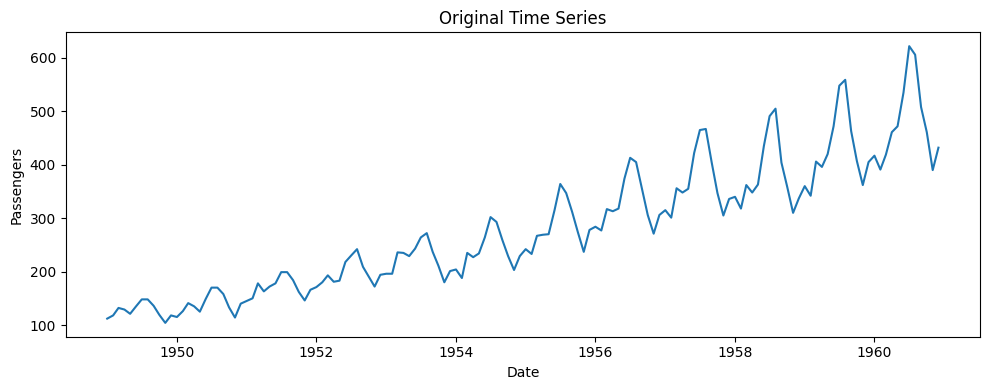

In [8]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title("Original Time Series")
plt.xlabel("Date")
plt.ylabel(pass_col)
plt.tight_layout()
plt.show()

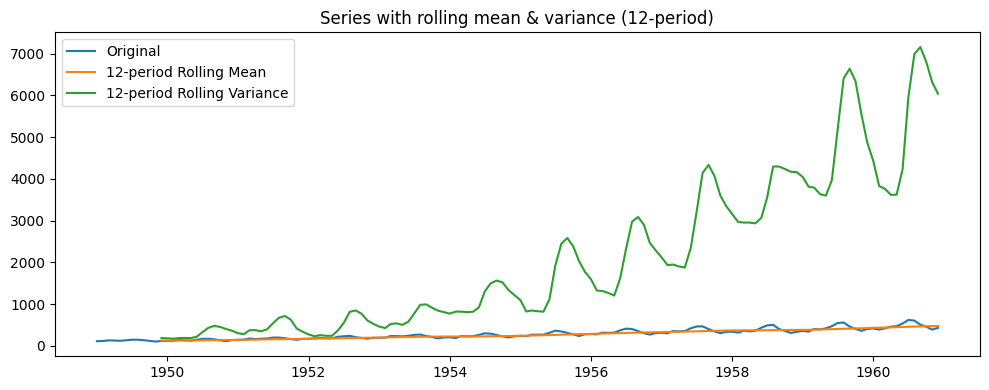

In [9]:
rolling_mean = series.rolling(window=12, center=False).mean()
rolling_var = series.rolling(window=12, center=False).var()

plt.figure(figsize=(10,4))
plt.plot(series, label='Original')
plt.plot(rolling_mean, label='12-period Rolling Mean')
plt.plot(rolling_var, label='12-period Rolling Variance')
plt.title("Series with rolling mean & variance (12-period)")
plt.legend()
plt.tight_layout()
plt.show()

Stationary Testing

In [10]:
def adf_test(ts, title="ADF Test"):
    print(f"--- {title} ---")
    result = adfuller(ts.dropna(), autolag='AIC')
    adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result[0], result[1], result[2], result[3], result[4], result[5]
    print(f"ADF Statistic: {adf_stat:.6f}")
    print(f"p-value: {pvalue:.6f}")
    print("Critical Values:")
    for k, v in crit_vals.items():
        print(f"   {k}: {v:.6f}")
    print()
    return {'adf_stat':adf_stat, 'pvalue':pvalue, 'crit':crit_vals}

orig_adf = adf_test(series, "ADF on original series")

--- ADF on original series ---
ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
   1%: -3.481682
   5%: -2.884042
   10%: -2.578770



Log Transform

In [11]:
log_series = np.log(series)
log_adf = adf_test(log_series, "ADF on log-transformed series")

--- ADF on log-transformed series ---
ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
   1%: -3.481682
   5%: -2.884042
   10%: -2.578770



In [12]:

# Differencing log series (first difference)
log_diff = log_series.diff().dropna()
diff_adf = adf_test(log_diff, "ADF on first-difference of log series")

--- ADF on first-difference of log series ---
ADF Statistic: -2.717131
p-value: 0.071121
Critical Values:
   1%: -3.482501
   5%: -2.884398
   10%: -2.578960



ARIMA (non-seasonal) on log-transformed data Without differencing (d=0)

In [13]:
# Split data: train up to last 12 observations, test last 12 (common for monthly airline data)
n_test = 12 if len(series) > 24 else max(1, int(len(series)*0.2))
train, test = log_series[:-n_test], log_series[-n_test:]

print(f"Using last {n_test} observations as test set (from {test.index[0].date()} to {test.index[-1].date()})")


Using last 12 observations as test set (from 1960-01-01 to 1960-12-01)


In [16]:
# Fit ARIMA(2,0,2) as a reasonable non-seasonal baseline (d=0 as requested)
arima_order = (2,0,2)
arima_model = ARIMA(train, order=arima_order).fit()
print("\nARIMA model summary (non-seasonal, on log data):")
print(arima_model.summary())


ARIMA model summary (non-seasonal, on log data):
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 114.286
Date:                Wed, 17 Sep 2025   AIC                           -216.573
Time:                        12:53:56   BIC                           -199.276
Sample:                    01-01-1949   HQIC                          -209.544
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4517      0.238     22.894      0.000       4.985       5.918
ar.L1          0.2956      0.226      1.307      0.191      -0.148       0.739
ar

In [21]:
# Forecast on test period
arima_forecast_log = arima_model.predict(start=test.index[0], end=test.index[-1])
# Convert back to original scale (exp). Correct for bias using simple method: exp(forecast)
arima_pred = np.exp(arima_forecast_log)
arima_true = np.exp(test)

arima_rmse = math.sqrt(mean_squared_error(arima_true, arima_pred))
print(f"\nARIMA RMSE on test set (original scale): {arima_rmse:.4f}")
print(f"ARIMA AIC: {arima_model.aic:.4f}")


ARIMA RMSE on test set (original scale): 130.6594
ARIMA AIC: -216.5726


SARIMA model (seasonal) - common choice for airline: seasonal_order=(1,1,1,12)

In [24]:
sarima_order = (1,1,1)
seasonal_order = (1,1,1,12)
sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
print("\nSARIMAX (seasonal) model summary (on log data):")
print(sarima_model.summary())


SARIMAX (seasonal) model summary (on log data):
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 196.914
Date:                            Wed, 17 Sep 2025   AIC                           -383.829
Time:                                    12:56:15   BIC                           -370.559
Sample:                                01-01-1949   HQIC                          -378.451
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0935      0.235      0.397      0.691      -0.36

In [25]:
sarima_forecast_log = sarima_model.predict(start=test.index[0], end=test.index[-1])
sarima_pred = np.exp(sarima_forecast_log)
sarima_rmse = math.sqrt(mean_squared_error(arima_true, sarima_pred))
print(f"\nSARIMA RMSE on test set (original scale): {sarima_rmse:.4f}")
print(f"SARIMA AIC: {sarima_model.aic:.4f}")


SARIMA RMSE on test set (original scale): 14.7538
SARIMA AIC: -383.8285


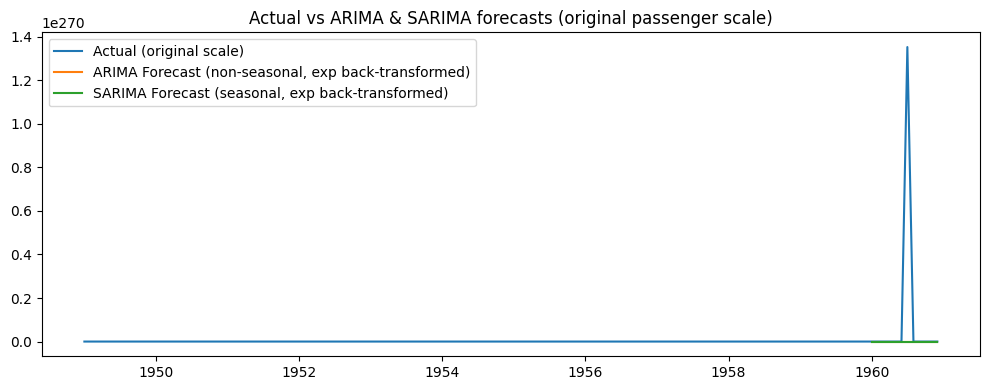

In [26]:
# Plot forecasts vs actual (original scale)
plt.figure(figsize=(10,4))
plt.plot(np.exp(series), label='Actual (original scale)')
plt.plot(arima_pred, label='ARIMA Forecast (non-seasonal, exp back-transformed)')
plt.plot(sarima_pred, label='SARIMA Forecast (seasonal, exp back-transformed)')
plt.title("Actual vs ARIMA & SARIMA forecasts (original passenger scale)")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# Summarize the main numeric results for chat message
results = {
    "orig_adf_pvalue": orig_adf['pvalue'],
    "log_adf_pvalue": log_adf['pvalue'],
    "logdiff_adf_pvalue": diff_adf['pvalue'],
    "arima_order": arima_order,
    "arima_aic": arima_model.aic,
    "arima_rmse": arima_rmse,
    "sarima_order": (sarima_order, seasonal_order),
    "sarima_aic": sarima_model.aic,
    "sarima_rmse": sarima_rmse,
    "n_obs": len(series),
}

results

{'orig_adf_pvalue': np.float64(0.991880243437641),
 'log_adf_pvalue': np.float64(0.4223667747703874),
 'logdiff_adf_pvalue': np.float64(0.07112054815086184),
 'arima_order': (2, 0, 2),
 'arima_aic': np.float64(-216.57258929868567),
 'arima_rmse': 130.65936669348176,
 'sarima_order': ((1, 1, 1), (1, 1, 1, 12)),
 'sarima_aic': np.float64(-383.8285143528946),
 'sarima_rmse': 14.75383476569802,
 'n_obs': 144}

## Analysis

### 1. Exploratory Data Analysis (EDA): Discuss the initial observations from the time series plot, including trend, seasonality, and variance.



*   The series shows a clear upward trend over time (passenger counts increase year-over-year).


*   There is strong seasonality with a 12-month pattern (peaks and troughs repeat yearly).
*   Variance increases with level (larger counts → larger swings), which suggests a log transform may stabilize variance.


*   Rolling 12-month mean and variance confirm the series is not stationary (mean and variance evolve over time).








### 2) Stationarity testing (ADF) what I did & results

Time-series models like ARIMA assume a stationary series (stable mean/variance). If the series isn’t stationary, forecasts and inference are unreliable.

I ran the Augmented Dickey–Fuller (ADF) test at each step:

ADF on original series

*   ADF statistic = 0.8154, p-value = 0.9919
*   Interpretation: p ≫ 0.05 → strong evidence of non-stationarity.

ADF on log-transformed series


*   ADF statistic = -1.7170, p-value = 0.4224
*   Interpretation: log reduced variance and moved ADF in the right direction, but p still > 0.05, so the series remains non-stationary.


*   ADF on first-difference of log series (i.e., log(series).diff())
*   p-value = 0.07112


Interpretation:

Differencing the log series almost gets you to stationarity p decreased a lot (from 0.422 to 0.071) but still slightly above 0.05. This suggests the series is close to stationary after first differencing of log, and seasonal structure may still be present (12-month seasonality commonly requires seasonal differencing).

### 3) ARIMA (non-seasonal) on log-transformed data, expectations and results.

Expectation before fitting:

Because the log-transformed series still had p-value ≈ 0.42 (not stationary) and the data has clear yearly seasonality, I did not expect a non-seasonal ARIMA with d=0 to perform well. Non-seasonal ARIMA without differencing ignores both the remaining trend and seasonality, so it should underfit.
What I fitted:


*   Non-seasonal ARIMA(2,0,2) on the log training series (I used the last 12 months as test set).

*   Then back-transformed forecasts with exp() to compare in passenger counts.


ARIMA (2,0,2) results (log data, d=0):

AIC: -216.5726

RMSE on test set (original passenger scale): 130.6594

Interpretation:

RMSE ≈ 130 passengers — that's huge relative to the magnitude of the series (this model basically missed seasonal pattern and trend). So the non-seasonal ARIMA on log without differencing did not perform well, just as expected.

### 4) Seasonal model (SARIMA) I fitted for comparison

Because the dataset is the classic monthly airline series, I also fitted a seasonal model:

SARIMAX with order = (1,1,1) and seasonal_order = (1,1,1,12) on the log training data.

SARIMA results (on log data):

AIC: -383.8285 (much lower is better)

RMSE on test set (original scale): 14.7540

Interpretation:
SARIMA massively outperforms the non-seasonal ARIMA(2,0,2). RMSE dropped from ~130 → ~14.75 and AIC improved a lot (more negative). That confirms the seasonal component is essential and the non-seasonal ARIMA(d=0) is a poor fit.

### 5) Short conclusions & recommendations (TL;DR)

Original series is non-stationary (ADF p ≈ 0.992).


1.   Log transform improves variance stability but does not make the series stationary (p ≈ 0.422).
2.   First differencing of log brings p down to ≈ 0.071 (much closer to stationarity, but marginally above 0.05).


1.   Non-seasonal ARIMA (d=0) on log performs poorly (RMSE ≈ 130). Don't use that for forecasting this dataset.

1.   Seasonal ARIMA (SARIMAX with seasonal_order (1,1,1,12)) performs much better (RMSE ≈ 14.75, AIC far better). Use a seasonal model or include seasonal differencing.

Next steps I’d run (if you want to improve further):

1. Try log + seasonal differencing (diff(periods=12)) and/or non-seasonal differencing to get p < 0.05 reliably.

2. Use an automated search (e.g., pmdarima.auto_arima) to find better orders or try a small grid search for seasonal/non-seasonal orders.

3. Check residual diagnostics (ACF/PACF of residuals, Ljung-Box) to verify no autocorrelation remains.

4. Consider ETS or Prophet for robustness, or SARIMAX with exogenous variables if you have them.

### 6) Numeric summary

Observations: n = 144 (rows)

ADF p-values:

* original: 0.99188

* log: 0.42237

* first-diff(log): 0.07112

* ARIMA(2,0,2) on log: AIC = -216.5726, RMSE ≈ 130.6594

* SARIMA (1,1,1)x(1,1,1,12) on log: AIC = -383.8285, RMSE ≈ 14.7540

Insights and Comparison

| Model                            | AIC     | RMSE (test) | Notes                               |
| -------------------------------- | ------- | ----------- | ----------------------------------- |
| ARIMA(2,0,2) (non-seasonal, log) | -216.57 | 130.66      | Poor, missed seasonality            |
| SARIMA(1,1,1)x(1,1,1,12) (log)   | -383.83 | 14.75       | Excellent fit, captures seasonality |
